In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
import torchvision
from timeit import default_timer as timer # 计时

In [2]:
# transforms for images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),   
    torchvision.transforms.ToTensor(),      
    torchvision.transforms.RandomHorizontalFlip(p = 0.5) # 随机水平翻转
])


# datasets
trainset = torchvision.datasets.ImageFolder("../datasets/DogBreeds/train", transform = transforms)
testset = torchvision.datasets.ImageFolder("../datasets/DogBreeds/test", transform = transforms)

# batche_size
batch_size = 100

# loaders for datasets
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size, shuffle = True)

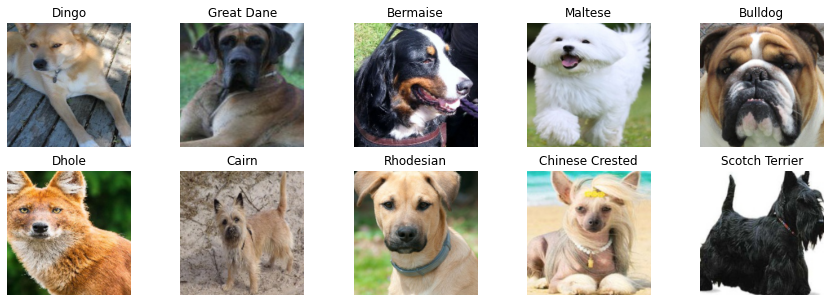

In [3]:
images, labels = iter(trainloader).next() # 获取一个batch的 images 和 labels, images.shape(100, 3, 224, 224)
images, labels = images.numpy(), labels.numpy()

figure = plt.figure(figsize = (15,5))
for i in range(10): # show 10 images
    figure.add_subplot(2, 5, i + 1)
    plt.title(trainset.classes[labels[i]])
    plt.axis("off")
    plt.imshow(np.transpose(images[i], (1,2,0))) # (3, 224, 224) -> (224, 224, 3) ：(C, H, W) -> (H, W, C)
plt.show()

In [4]:
# num of batches
print("number of train batches : ", len(trainloader)) # 8000 images in total
print("number of test batches : ", len(testloader))

number of train batches :  80
number of test batches :  7


In [5]:
# 显示类名
print("Classes : ", trainset.classes)

Classes :  ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


In [6]:
# Whether to train on a gpu
my_gpu = torch.cuda.is_available()
print(f'Train on gpu: {my_gpu}')
device = torch.device('cuda' if my_gpu else 'cpu') # 获得device
print(f"My device: {torch.cuda.get_device_name(0)}")

Train on gpu: True
My device: NVIDIA GeForce RTX 2060 with Max-Q Design


In [7]:
model = torchvision.models.resnet18(pretrained = True) # Use pre-trained ResNet 18 model


# freeze model params because the method being used is transfer learning
# 使用迁移学习, 冻结参数
for param in model.parameters():
    param = param.requires_grad_(False)

# new layer that is used to creat a array of log probabilities for prediction
# 我们将最后一层的fc替换掉
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 256),
                      nn.ReLU(),
                      nn.Linear(256, len(trainset.classes)),                   
                      nn.LogSoftmax(dim=1)) # LogSoftmax 就是在 Softmax的返回值上进行log运算, 这会放大输出值从而使得loss更大, 反向更新时更新的更多, 从而更快收敛


print("The new layer is : ",model.fc)
model = model.to(device) # Move model to GPU

The new layer is :  Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=70, bias=True)
  (3): LogSoftmax(dim=1)
)


[1, 0] Loss: 0.438 Accuracy: 0.83 Progress: 1.25% 
[1, 10] Loss: 0.903 Accuracy: 0.79 Progress: 13.75% 
[1, 20] Loss: 0.636 Accuracy: 0.74 Progress: 26.25% 
[1, 30] Loss: 0.382 Accuracy: 0.89 Progress: 38.75% 
[1, 40] Loss: 0.303 Accuracy: 0.85 Progress: 51.25% 
[1, 50] Loss: 0.588 Accuracy: 0.85 Progress: 63.75% 
[1, 60] Loss: 0.565 Accuracy: 0.84 Progress: 76.25% 
[1, 70] Loss: 0.626 Accuracy: 0.84 Progress: 88.75% 
[2, 0] Loss: 0.497 Accuracy: 0.83 Progress: 1.25% 
[2, 10] Loss: 0.366 Accuracy: 0.89 Progress: 13.75% 
[2, 20] Loss: 0.607 Accuracy: 0.84 Progress: 26.25% 
[2, 30] Loss: 0.371 Accuracy: 0.85 Progress: 38.75% 
[2, 40] Loss: 0.511 Accuracy: 0.80 Progress: 51.25% 
[2, 50] Loss: 0.471 Accuracy: 0.86 Progress: 63.75% 
[2, 60] Loss: 0.540 Accuracy: 0.87 Progress: 76.25% 
[2, 70] Loss: 0.848 Accuracy: 0.92 Progress: 88.75% 
[3, 0] Loss: 0.253 Accuracy: 0.82 Progress: 1.25% 
[3, 10] Loss: 0.579 Accuracy: 0.83 Progress: 13.75% 
[3, 20] Loss: 0.465 Accuracy: 0.87 Progress: 26.25% 

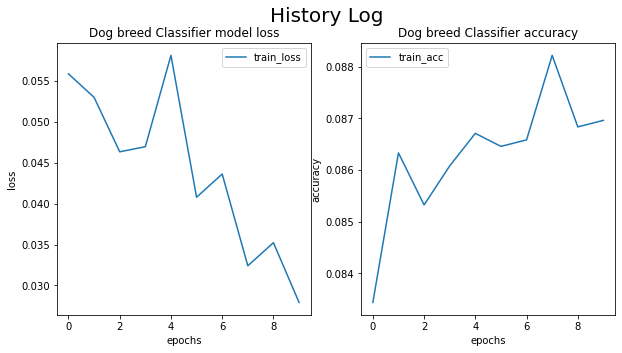

In [12]:
# define hyper parameters
lr = 0.01
epochs = 20

optimizer = optim.Adam(model.parameters() , lr = lr)
loss_func = nn.CrossEntropyLoss() # CrossEntropyLoss for multiclass classfication

history = []

overall_start = timer()


for epoch in range(epochs):
    
    # Track of training loss and accuracy for each epoch
    train_loss = 0.0
    train_acc = 0.0

    # switch to train mode, 只影响某些模块, 如 BN和Dropout
    model.train()

    for step, (data, target) in enumerate(trainloader):
        if my_gpu:
            data, target = data.to(device), target.to(device) # [100, C, H, W]
        # Compute prediction and loss
        pred = model(data)
        loss = loss_func(pred, target)
        
        # Backpropagation and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track train loss by multiplying average loss by number of examples in batch
        
    
        if step % 10 == 0: # 每 10 个 batches 打印一次, 即 1000 张图片的训练后, 打印一次
            test_x, test_y = iter(testloader).next() # test_x.shape(100,3,224,224)
            if my_gpu:
                test_x, test_y = test_x.to(device), test_y.to(device)
            test_out = model(test_x)                  # test_out.shape (100, 70) 输出这一批(batch)的prop
            test_pred = torch.argmax(test_out, dim=1) # test_pred.shape(100, 1) 输出这一批(batch)的pred
            accuracy = sum(test_pred == test_y) / len(test_y)

            train_loss += loss.item() * data.size(0)
            train_acc += accuracy * data.size(0)

            print(f'[{epoch+1}, {step}] Loss: {loss:.3f} Accuracy: {accuracy :.2f} Progress: {100 * (step + 1) / len(trainloader):.2f}% ')
    
    # 在for循环结束后执行else
    else:
        # Calculate average losses
        train_loss = train_loss / len(trainset)
        train_acc = train_acc / len(trainset)
        history.append([train_loss, train_acc])

total_time = timer() - overall_start
print('Training finished')
print(f'total {total_time} seconds elapsed')

# 可视化loss和acc
history = pd.DataFrame(history, columns=['train_loss', 'train_acc'])
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('History Log',  size = 20)

axs[0].plot(history["train_loss"], label = "train_loss")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].set_title('Dog breed Classifier model loss')

axs[1].plot(history["train_acc"], label = "train_acc")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].set_title('Dog breed Classifier accuracy')
plt.show()

# save model's parameters
torch.save(model.state_dict(), "model_weights_resnet18.pth")

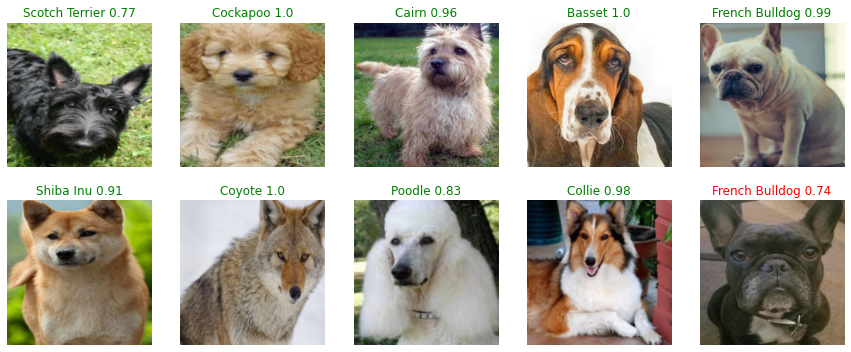

In [9]:
# 测试
images, labels = iter(testloader).next()

# get predictions
model.eval()
with torch.no_grad():
    out = model(images.cuda()) # out.shape (100, 70) 对于 100 张图片, 输出每一种breed的概率
    probs = f.softmax(out, dim=1).sort(descending = True) # 转换成概率
    preds = torch.argmax(out, dim=1) # 最大概率品种

figure = plt.figure(figsize=(15 , 6))

images = images.cpu().numpy()
for i in range(10):
    figure.add_subplot(2, 5, i + 1)
    plt.title(testset.classes[preds[i]] + " "+ str(round(probs.values[i][0].item(), 2)), color=("green" if preds[i]==labels[i] else "red"))
    plt.axis("off")
    plt.imshow(np.transpose(images[i], (1,2,0))) # (3, 224, 224) -> (224, 224, 3)
plt.show()

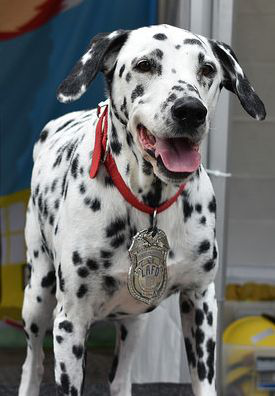

In [10]:
import requests
from io import BytesIO
from PIL import Image

# random image from the web
url = "http://123.56.93.179/dalmation.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [11]:
img = transforms(img)
out = model(img.unsqueeze(0).cuda())
prob = f.softmax(out, dim=1)
pred = torch.argmax(out, dim=1)
print(trainset.classes[pred])
print(prob)

Dalmation
tensor([[3.3930e-11, 3.1755e-10, 1.5887e-14, 3.7422e-09, 8.5961e-08, 1.9016e-10,
         3.1139e-06, 7.8302e-08, 7.8916e-14, 1.7827e-13, 3.6830e-15, 1.0447e-10,
         3.4536e-11, 6.6286e-06, 1.1950e-08, 5.2873e-07, 4.9483e-12, 3.6971e-09,
         6.5204e-12, 1.6644e-09, 2.8646e-10, 2.4502e-17, 1.4425e-11, 3.3879e-05,
         2.7717e-19, 8.1868e-11, 1.9890e-14, 4.0258e-09, 4.7349e-11, 1.4086e-09,
         3.4077e-15, 9.9913e-01, 1.7653e-15, 1.0376e-12, 5.3875e-11, 4.7027e-16,
         2.1656e-15, 4.8766e-13, 1.7653e-12, 8.2886e-04, 5.8814e-12, 5.0016e-07,
         7.2107e-12, 1.0606e-10, 4.0582e-11, 1.1038e-11, 1.0894e-12, 4.4936e-15,
         3.5161e-09, 1.3285e-15, 2.6380e-11, 2.9141e-13, 5.5285e-10, 6.0249e-14,
         4.6487e-17, 1.8926e-10, 3.0354e-15, 1.7035e-08, 4.1755e-11, 1.0992e-10,
         1.0264e-12, 4.1394e-11, 4.0319e-12, 4.0630e-15, 3.0985e-12, 1.0082e-12,
         1.4351e-14, 8.4227e-10, 2.8177e-11, 1.5449e-15]], device='cuda:0',
       grad_fn=<Softmax